# TP Coding Convolutional Neural Networks in tensorflow and keras

For any remark or suggestion, please feel free to contact me at:
geoffroy.peeters@telecom-paristech.fr

Last edit: 2018/12/14 geoffroy.peeters@telecom-paristech.fr

### Objective:

We want to implement a Convolutional Neural Network (CNN) to do image recognition. For this we will use the well-known CIFAR-10 dataset https://www.cs.toronto.edu/~kriz/cifar.html.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

We will first code the simple ConvNet described below using tensorflow https://www.tensorflow.org envirronment, then do the same using keras https://keras.io.

- The input of the CNN is a set of (32,32,3) image tensors.
- We apply 
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - a ReLu activation function
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2à (i.e. we reduce by two the size in each dimension)
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - A softmax activation function which outputs are the $P(y_c | X)$ (multi-class problem)



# Load packages

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Import data

We first import CIFAR-10 dataset.

In [2]:
from keras.utils.np_utils import to_categorical

from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)
print(np.unique(y_train))

Using TensorFlow backend.


170500096/170498071 [==============================] - 10s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
[0 1 2 3 4 5 6 7 8 9]


The CIFAR-10 dataset has 10 classes. These are the following :

In [0]:
cifar_10_list = [ 'airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

### Display some of the images

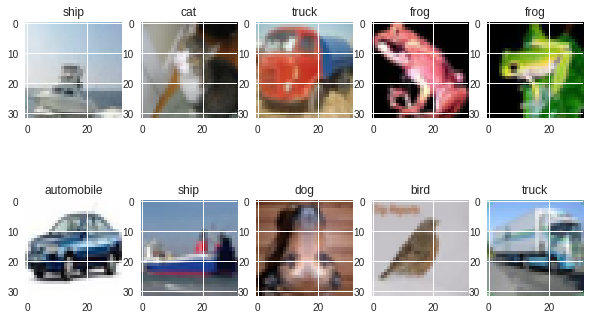

In [4]:
plt.figure(figsize=(10, 6))
for idx,i in enumerate(range(100,110)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(X_train[i, :, :, :])
    plt.title(cifar_10_list[int(y_train[i])])

## Format conversion

We now convert the format of the data. In the case of CNNs, and contrary to MLPs, the inputs are not simply vectors of arbitrary size. For example, in the case of images, it is important to distinguish the different dimensions (otherwise the network would not know how to carry out convolutions). Therefore, you need to carry out the following operation :

- reshape the input ```X_train```and ```X_test``` to a set of matrices of size (32,32) and depth 3 (for the 3 R,G,B colors), convert the data to float32 and normalize them in the range [0,1]. The final dimensions of the image data should be : [batch_size, height, width, n_channels]

Furthermore, as in the previous lab work, you must also convert the label vectors to matrices with k columns, where k is the number of classes. This allows us to carry out the cross-entropy for multi-class problems. Therefore :

- convert the output label ```y_train``` and ```y_test``` to one-hot encoding format.

In [5]:
# input image dimensions
img_rows, img_cols, nb_channels = 32, 32, 3
nb_classes = 10

# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('Y_train shape:', Y_train.shape)
print('There is {} train data'.format(X_train.shape[0]))
print('There is {} test data'.format(X_test.shape[0]))
print(img_rows, img_cols, nb_channels)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
Y_train shape: (50000, 10)
There is 50000 train data
There is 10000 test data
32 32 3


# 1. CNN with tensorflow

We are now going to create a CNN with Tensorflow, and train it on the previously loaded CIFAR dataset.
- First define the input and output using ```tf.placeholder```
- Define the weights W1,b1,W2,b2 of the CNN using ```tf.get_variable```
    - We initialize them using ```tf.contrib.layers.xavier_initializer```(see https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer)
- Perform the convolution using ```tf.nn.conv2d``` 
- Apply the activation function using ```tf.nn.relu```
- Perform the max pooling using ```tf.nn.max_pool```
- Flatten the output of the convolution using ```tf.contrib.layers.flatten```
- Perform the Fully-Connected part using ```tf.contrib.layers.fully_connected```

Also, note that in Tensorflow, you can carry out the softmax + cross entropy all in one step with the following function :

- ```tf.nn.softmax_cross_entropy_with_logits()```

This has the advantage of being optimised and stabilised by the programmers who wrote Tensorflow, so that you do not have numerical problems.

In [0]:
import tensorflow as tf

learning_rate = 0.01
n_epochs = 20
batch_size = 64

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)


# --- Size of the successice layers
n_h_0 = nb_channels
n_h_1 = nb_filters
n_h_2 = nb_filters

In [0]:
tf.reset_default_graph()

# input tensor are of shape [batch, in_height, in_width, in_channels]  
# filter / kernel tensor are of shape [filter_height, filter_width, in_channels, out_channels]

X_input = tf.placeholder(tf.float32, shape=[None, img_rows, img_cols, nb_channels], name='X_input')
Y_output = tf.placeholder(tf.float32, shape=[None, nb_classes], name='Y_output')
W1 = tf.get_variable("W1", shape=[3, 3, n_h_0, n_h_1], initializer=tf.contrib.layers.xavier_initializer())
W2 = tf.get_variable("W2", shape=[3, 3, n_h_1, n_h_2], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable("b1", shape = [nb_filters])
b2 = tf.get_variable("b2", shape = [nb_filters])

Z1 = tf.nn.conv2d(input=X_input,
                   filter=W1,
                   strides=[1, 1, 1, 1],
                   padding='SAME') + b1                 
A1 = tf.nn.relu(Z1)

Z2 = tf.nn.conv2d(input=A1,
                   filter=W2,
                   strides=[1, 1, 1, 1],
                   padding='SAME') + b2
A2 = tf.nn.relu(Z2)
A2 = tf.nn.max_pool(value=A2,
                     ksize=[1, 2, 2, 1],
                     strides=[1, 2, 2, 1],
                     padding='SAME') 

Z3 = tf.contrib.layers.flatten(A2)
Z3 = tf.contrib.layers.fully_connected(Z3, num_outputs=nb_classes)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y_output))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

## Train the model

In [0]:
init = tf.global_variables_initializer()
n_batches = int(np.ceil(X_train.shape[0] / float(batch_size)))
costs = []

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        minibatch_cost = 0.
        for batch_idx in range(n_batches):
            start = batch_idx * batch_size
            stop = start + batch_size
            _ , temp_cost = sess.run([optimizer, cost], feed_dict={X_input: X_train[start: stop,:,:,:], Y_output: Y_train[start: stop,:]})
            minibatch_cost += temp_cost / n_batches

        if epoch % 1 == 0:
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            
        costs.append(minibatch_cost) 
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Calculate the correct predictions
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y_output, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print(accuracy)
    train_accuracy = accuracy.eval({X_input: X_train, Y_output: Y_train})
    test_accuracy = accuracy.eval({X_input: X_test, Y_output: Y_test})
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    


# 2. CNN with keras

We are now going to create the same network with Keras. As we shall see, the interfance is quite simplified in comparison to Tensorflow.

## We first import keras packages

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
print(keras.__version__)

Using TensorFlow backend.


2.2.4


## We define the parameters of the model, and of the training

In [0]:
input_shape = (img_rows, img_cols, nb_channels)

## Create the CNN model in Keras using the Sequential API

Keras has a simple way of adding layers to create a neural network. First, you can indicate to Keras that the model is 'sequential', that is to say, a straight-forward CNN. For this, you can use the following function :
- ```model = Sequential()```

After this, you can add layers with the function.

- ```model.add()```

You can then use the ```Conv2D```, ```Activation```, ```MaxPooling2D```, ```Flatten``` and ```Dense``` (fully connected) functions to specify different layer types.

Create your CNN now with the network parameters specified above.

In [0]:
model = Sequential()
model.add(Conv2D(filters=nb_filters, kernel_size=3,
                 activation='relu',
                 input_shape=input_shape))  
model.add(Conv2D(nb_filters, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


## Compile the model

We define here the ```loss``` that we will minimize and the ```optimizer``` (the specific algorithm used to perform gradient descent).

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

## We display a summary of the model created (but not yet trained)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                62730     
Total params: 72,874
Trainable params: 72,874
Non-trainable params: 0
_________________________________________________________________


## Perform the training

In [0]:
n_train_samples = 10000
model.fit(X_train[:n_train_samples], Y_train[:n_train_samples],
          batch_size=batch_size, 
          nb_epoch=n_epochs,
          verbose=1, 
          validation_data=(X_test, Y_test))

## We evaluate the performances of the model on the test data

In [0]:
score = model.evaluate(X_test, Y_test, verbose=False)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Let's take a look at what the network has learned. What do you think ?

In [0]:
plt.figure(figsize=(10, 6))
for idx,i in enumerate(range(100,110)):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    predicted_class = np.argmax(np.squeeze(model.predict(np.expand_dims(X_test[rand_ind,:,:,:],axis=0))))
    plt.imshow(X_test[rand_ind,:,:,:])
    plt.title(cifar_10_list[int(predicted_class)])

## We display all (32) trained filters of the first layer

In [0]:
print(model.layers[0].filters)
print(model.layers[0].kernel_size)
print(model.layers[0].get_weights()[0].shape)
plt.figure(figsize=(10, 6))
# filts = model.predict(np.expand_dims(X_test[:32,:,:,:],axis=0))[0]
for num in range(0,32):
    plt.subplot(8, 4, num+1)
    
    t = model.predict(np.expand_dims(X_test[num,:,:,:],axis=0))[0]
    plt.imshow(filts[:,:,num])
#     plt.imshow(model.layers[0].output[num,:,:,:])

      